<a href="https://colab.research.google.com/github/tfysekis/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Domain Selection and Dataset Creation

In this project, we will conduct sentiment analysis using the Amazon Fine Food Reviews dataset. This dataset contains over 500,000 customer reviews of food products available on Amazon, making it a rich resource for analyzing customer opinions. Each review includes both the text of the review and a numerical rating (1–5), which we will use to classify sentiment into three categories:

- Positive: Ratings of 4 or 5
- Neutral: A rating of 3
- Negative: Ratings of 1 or 2

## Load the Dataset

In [1]:
import pandas as pd  # Library for working with data

# Try to load the dataset
try:
    # Reads the uploaded file into a pandas DataFrame
    df = pd.read_csv('Reviews.csv', encoding='utf-8')

    # Show the first 5 rows
    print(df.head())

    # Display the total number of rows
    print("Total number of rows in the dataset:", df.shape[0])

except FileNotFoundError:
    print("The file was not found. Check if the file is uploaded correctly and the name is typed correctly.")
except Exception as e:
    print("An error occurred:", e)


   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

## Check the Data

Data Integrity Check: This step involves checking for missing values in each column of the dataset to ensure data integrity. Missing values can impact model performance, so identifying and addressing them is crucial for reliable analysis and accurate predictions.

In [2]:
# Check for missing values in each column
missing_values = df.isnull().sum()

# Display the count of missing values for each column
print(missing_values)

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


## Data Cleansing: Addressing Missing Values in Review Data



We identified 26 missing values in the ProfileName column and 27 in the Summary column. To ensure data quality and consistency, we will remove these rows with missing values before proceeding with further analysis.

In [3]:
# Remove rows where any of these columns have missing values
df_cleaned = df.dropna(subset=['ProfileName', 'Summary'])

# Check the shape of the new DataFrame to see how many rows are left
print("New number of rows after removing missing values:", df_cleaned.shape[0])

# Optionally, check again for missing values to ensure they're all handled
print(df_cleaned.isnull().sum())

New number of rows after removing missing values: 568401
Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64


## Data Preprocessing: Streamlining and Cleansing the Review Datase

Now, we will focus on removing columns that are not essential for our sentiment analysis. Specifically, we will exclude columns such as
- Id
- ProductId
- UserId
- ProfileName
- HelpfulnessNumerator
- HelpfulnessDenominator
- Time
- Score

These columns are primarily identifiers and metadata that do not contribute to the sentiment analysis process. We will retain only the Summary and Text columns, as these contain the actual review content which is crucial for analyzing and understanding user sentiments.

In [4]:
# Columns to keep that are likely useful for sentiment analysis
columns_to_keep = ['Score', 'Summary', 'Text']

# Reducing the DataFrame to only necessary columns
df_reduced = df_cleaned[columns_to_keep]

# Check the cleaned data structure
print("Total rows after cleaning:", df_cleaned.shape[0])

Total rows after cleaning: 568401


## **Transform Ratings into Sentiment Categories**

Now, it's finally time to transform the numerical ratings into sentiment categories to prepare the data for analysis. The transformation is as follows:
- **Positive**: Ratings of 4 or 5.
- **Neutral**: A rating of 3.
- **Negative**: Ratings of 1 or 2.

This categorization simplifies the analysis by converting numerical ratings into meaningful sentiment labels, which will serve as the target variable for our sentiment analysis models.

In [5]:
# Explicitly create a copy of the reduced DataFrame
df_reduced = df_cleaned[columns_to_keep].copy()

# Function to categorize ratings
def categorize_rating(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

# Apply function to the 'Score' column
df_reduced['Sentiment'] = df_reduced['Score'].apply(categorize_rating)

# Print the first 10 rows to see the original scores and their corresponding sentiments
print(df_reduced[['Score', 'Sentiment']].head(10))
print("Total rows after cleaning:", df_reduced.shape[0])


   Score Sentiment
0      5  Positive
1      1  Negative
2      4  Positive
3      2  Negative
4      5  Positive
5      4  Positive
6      5  Positive
7      5  Positive
8      5  Positive
9      5  Positive
Total rows after cleaning: 568401


# 2. Preprocessing and Text Analysis

Drop the Score Column, now that we have the sentiment, we dont need it.

In [6]:
#Dropping the 'Score' column from the DataFrame
df_reduced.drop(columns=['Score'], inplace=True)

## Comprehensive Text Cleaning and Preprocessing

This section of the code is designed to clean and preprocess the text data from your dataset. It involves several steps that prepare the text for further NLP tasks such as sentiment analysis. The cleaning function will remove HTML tags, URLs, special characters, convert text to lowercase, and remove stopwords. We apply this function to both the Summary and Text columns to ensure they are uniformly cleaned.

In [7]:
# Import necessary libraries
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

# Download necessary NLTK resources
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define a comprehensive cleaning function
def clean_and_preprocess(text):
    # Check if the input is valid HTML (optional but recommended)
    if '<' in text and '>' in text:
        text = BeautifulSoup(text, "lxml").get_text()
    else:
        text = text  # Skip BeautifulSoup if it’s not valid HTML

    # Remove URLs and special characters
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Special characters

    # Convert text to lowercase
    text = text.lower().strip()

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text


# Handle null values and apply the cleaning function
# Check for and handle null values
df_reduced['Summary'] = df_reduced['Summary'].fillna('')
df_reduced['Text'] = df_reduced['Text'].fillna('')

# Apply the comprehensive cleaning and preprocessing function
df_reduced['Cleaned_Summary'] = df_reduced['Summary'].apply(clean_and_preprocess)
df_reduced['Cleaned_Text'] = df_reduced['Text'].apply(clean_and_preprocess)

# Display the cleaned text to verify
print(df_reduced[['Summary', 'Cleaned_Summary', 'Text', 'Cleaned_Text']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                 Summary        Cleaned_Summary  \
0  Good Quality Dog Food  good quality dog food   
1      Not as Advertised             advertised   
2  "Delight" says it all           delight says   
3         Cough Medicine         cough medicine   
4            Great taffy            great taffy   

                                                Text  \
0  I have bought several of the Vitality canned d...   
1  Product arrived labeled as Jumbo Salted Peanut...   
2  This is a confection that has been around a fe...   
3  If you are looking for the secret ingredient i...   
4  Great taffy at a great price.  There was a wid...   

                                        Cleaned_Text  
0  bought several vitality canned dog food produc...  
1  product arrived labeled jumbo salted peanutsth...  
2  confection around centuries light pillowy citr...  
3  looking secret ingredient robitussin believe f...  
4  great taffy great price wide assortment yummy ...  


## Text Vectorization Using TF-IDF

This section of the code is focused on transforming the preprocessed text into a numerical format that machine learning models can interpret and analyze. Using the TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer, we convert the cleaned text from the 'Summary' and 'Text' columns into a set of numerical features. TF-IDF measures not just the frequency of words in each document (text entry), but adjusts this frequency against the number of documents the words appear in, which helps to highlight words that are more important to the specific document. This is crucial for tasks like sentiment analysis or topic modeling where the significance of words plays a key role in understanding the content.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the cleaned text
tfidf_summary = tfidf_vectorizer.fit_transform(df_reduced['Cleaned_Summary'])
tfidf_text = tfidf_vectorizer.fit_transform(df_reduced['Cleaned_Text'])

# Optionally, display the shape of the vectorized data
print("TF-IDF Summary shape:", tfidf_summary.shape)
print("TF-IDF Text shape:", tfidf_text.shape)


TF-IDF Summary shape: (568401, 41201)
TF-IDF Text shape: (568401, 307176)


## Efficient Replacement of Common Terms with Count Tracking


This code efficiently replaces predefined common terms (e.g., abbreviations, contractions, and informal expressions) in the Cleaned_Summary and Cleaned_Text columns of the dataset with their standardized or expanded forms. It also tracks and reports the total number of replacements made.

Key Features:

- Regex-Based Replacement: Uses a compiled regular expression pattern for fast and memory-efficient replacements, ensuring only whole words are replaced.
- Replacement and Counting: Tracks the number of replacements for each column during the replacement process.
- Optimized Performance: Minimizes memory usage by combining replacement and counting into a single operation.

In [9]:
# Define a dictionary for common terms and their replacements
replacement_dict = {
    "e.g.": "for example",
    "i.e.": "that is",
    "etc.": "and so on",
    "Dr.": "Doctor",
    "vs.": "versus",
    "can't": "cannot",
    "won't": "will not",
    "n't": " not",
    "it's": "it is",
    "lol": "laugh out loud",
    "omg": "oh my god"
}


In [10]:
import re

# Convert the replacement dictionary into a regex pattern for efficient replacement
pattern = re.compile(r'\b(' + '|'.join(re.escape(term) for term in replacement_dict.keys()) + r')\b')

def replace_and_count_changes(text):
    """
    Replace terms in the text and count the number of replacements made.
    """
    # Initialize count of changes
    changes = 0

    # Function to replace and count replacements
    def replacement_function(match):
        nonlocal changes
        changes += 1
        return replacement_dict[match.group(0)]

    # Apply the replacement using regex
    replaced_text = pattern.sub(replacement_function, text)
    return replaced_text, changes

# Initialize counters
summary_changes_total = 0
text_changes_total = 0

# Apply replacements and count changes for 'Cleaned_Summary'
df_reduced['Cleaned_Summary'], summary_changes_col = zip(*df_reduced['Cleaned_Summary'].apply(replace_and_count_changes))
summary_changes_total = sum(summary_changes_col)

# Apply replacements and count changes for 'Cleaned_Text'
df_reduced['Cleaned_Text'], text_changes_col = zip(*df_reduced['Cleaned_Text'].apply(replace_and_count_changes))
text_changes_total = sum(text_changes_col)

# Total changes
total_changes = summary_changes_total + text_changes_total
print(f"Total replacements made: {total_changes}")
print(f"Replacements in 'Cleaned_Summary': {summary_changes_total}")
print(f"Replacements in 'Cleaned_Text': {text_changes_total}")

Total replacements made: 3578
Replacements in 'Cleaned_Summary': 596
Replacements in 'Cleaned_Text': 2982


# 3. Baseline Model Development

In this task, we'll:

1. Split the dataset into training and testing sets using a 70-30 split.
Vectorize the Cleaned_Text column using TF-IDF to prepare it for machine learning models.
2. Train and evaluate two baseline models:
3. Logistic Regression: A simple, effective classifier.
4. Support Vector Machine (SVM): Known for its robustness in text classification.
5. Compare their performance using metrics like accuracy, precision, recall, and F1 score.

## 1. Data Splitting

**Data Splitting: Preparing Training and Testing Sets**

In this step, we split the dataset into training and testing sets to evaluate model performance. Here's how the split is structured:

- **Features**: The `Cleaned_Text` column, containing the preprocessed review text, serves as the input for the model.
- **Target**: The `Sentiment` column, containing sentiment labels (Positive, Neutral, Negative), is the prediction target.

We use a **70-30 split**, where:
- **70%** of the data is allocated for training the model (`X_train`, `y_train`).
- **30%** is reserved for testing and evaluating the model (`X_test`, `y_test`).

This ensures the model is trained on a majority of the data while maintaining a separate dataset for unbiased evaluation.

In [11]:
from sklearn.model_selection import train_test_split

# Split the data
X = df_reduced['Cleaned_Text']  # Feature: Cleaned_Text
y = df_reduced['Sentiment']     # Target: Sentiment

# Train-test split (70-30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")



Training set size: 397880
Testing set size: 170521


## 2. Text Vectorization with TF-IDF

In this step, we use **TF-IDF (Term Frequency-Inverse Document Frequency)** vectorization to convert the textual data into numerical features that can be used by machine learning models. Here's what we do:

- **TF-IDF Vectorizer**:
  - Captures the importance of words in the text while reducing the impact of commonly used words (e.g., "the," "and").
  - Limits the number of features to 5000 for efficiency, focusing on the most informative words.

- **Process**:
  1. **Fit and Transform Training Data**: The TF-IDF vectorizer learns vocabulary from the training data and transforms the text into numerical features (`X_train_tfidf`).
  2. **Transform Testing Data**: The same vocabulary is applied to the testing data to ensure consistency.

- **Output**:
  - The transformed training data (`X_train_tfidf`) and testing data (`X_test_tfidf`) are sparse matrices, ready for input into machine learning models.

By the end of this step:
- We have numerical feature matrices for both training and testing data.
- The dimensions of these matrices are displayed, confirming the number of samples and features.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Using 5000 features for efficiency

# Fit and transform training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF vectorization complete.")
print(f"Training data shape: {X_train_tfidf.shape}")
print(f"Testing data shape: {X_test_tfidf.shape}")


TF-IDF vectorization complete.
Training data shape: (397880, 5000)
Testing data shape: (170521, 5000)


## **Logistic Regression for Sentiment Analysis**

In this step, we train a **Logistic Regression model** to classify sentiments (Positive, Neutral, Negative) using the TF-IDF-transformed text data.

- **Training**: The model is trained on `X_train_tfidf` (features) and `y_train` (labels).
- **Prediction**: It predicts sentiment labels for the test data (`X_test_tfidf`).
- **Evaluation**:
  - A **classification report** provides metrics such as precision, recall, and F1-score for each sentiment class.
  - A **confusion matrix** visualizes the model’s performance by comparing actual and predicted labels.

This approach serves as a **baseline model** for sentiment analysis, offering a simple yet effective way to understand the relationship between textual features and sentiment labels.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    Negative       0.74      0.67      0.70     24366
     Neutral       0.52      0.18      0.27     12835
    Positive       0.90      0.97      0.93    133320

    accuracy                           0.87    170521
   macro avg       0.72      0.61      0.63    170521
weighted avg       0.85      0.87      0.85    170521

Confusion Matrix:
[[ 16280    974   7112]
 [  2768   2371   7696]
 [  3089   1254 128977]]


## **Support Vector Machine (SVM) for Sentiment Analysis**

In this step, we use a **Support Vector Machine (SVM)** classifier to predict sentiment categories (Positive, Neutral, Negative) from the TF-IDF-transformed text data.

- **Training**: The `LinearSVC` model is trained on `X_train_tfidf` (features) and `y_train` (labels).
- **Prediction**: Sentiment labels are predicted for the test data (`X_test_tfidf`).
- **Evaluation**:
  - A **classification report** provides detailed metrics such as precision, recall, and F1-score for each sentiment class.
  - A **confusion matrix** visualizes the distribution of correct and incorrect classifications.

This step builds on the baseline approach by leveraging SVM, a powerful classifier known for handling high-dimensional data effectively, providing another perspective on sentiment prediction.

In [14]:
from sklearn.svm import LinearSVC

# Initialize and train SVM model
svm = LinearSVC(random_state=42)
svm.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_svm = svm.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report for SVM:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


Classification Report for SVM:
              precision    recall  f1-score   support

    Negative       0.72      0.67      0.70     24366
     Neutral       0.58      0.11      0.19     12835
    Positive       0.89      0.97      0.93    133320

    accuracy                           0.86    170521
   macro avg       0.73      0.59      0.61    170521
weighted avg       0.84      0.86      0.84    170521

Confusion Matrix:
[[ 16388    457   7521]
 [  3089   1462   8284]
 [  3133    589 129598]]


# 4. Deep Learning Model Development

## Sentiment Analysis Using LSTM Model

**Summary:**
This code builds, trains, and evaluates a **Long Short-Term Memory (LSTM)** deep learning model for sentiment analysis. The steps include:
1. **Tokenization and Padding**: Converts cleaned text into sequences and pads them to ensure uniform input size.
2. **Label Encoding**: Maps sentiment categories (Positive, Neutral, Negative) to numerical values.
3. **LSTM Model Architecture**:
   - An **Embedding layer** to convert words into dense vector representations.
   - An **LSTM layer** to capture sequential dependencies in the text.
   - Dense layers with dropout to improve generalization.
4. **Training and Evaluation**:
   - Trains the model on the dataset for 5 epochs.
   - Evaluates its performance using accuracy on the test set.

The final output provides the LSTM model's accuracy, giving insight into its effectiveness for sentiment classification tasks.

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Tokenize the text
max_words = 5000  # Vocabulary size
max_len = 100     # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_reduced['Cleaned_Text'])

# Convert text to sequences and pad them
X_seq = tokenizer.texts_to_sequences(df_reduced['Cleaned_Text'])
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Map Sentiment to numeric values
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
y = df_reduced['Sentiment'].map(sentiment_mapping).values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.3, random_state=42)

# Build the LSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 output classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"LSTM Model Accuracy: {accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
12434/12434 ━━━━━━━━━━━━━━━━━━━━ 2375s 191ms/step - accuracy: 0.8417 - loss: 0.4461 - val_accuracy: 0.8732 - val_loss: 0.3410
Epoch 2/5
12434/12434 ━━━━━━━━━━━━━━━━━━━━ 2403s 193ms/step - accuracy: 0.8779 - loss: 0.3339 - val_accuracy: 0.8845 - val_loss: 0.3223
Epoch 3/5
12434/12434 ━━━━━━━━━━━━━━━━━━━━ 2464s 198ms/step - accuracy: 0.8931 - loss: 0.2966 - val_accuracy: 0.8886 - val_loss: 0.3085
Epoch 4/5
12434/12434 ━━━━━━━━━━━━━━━━━━━━ 2436s 195ms/step - accuracy: 0.9051 - loss: 0.2651 - val_accuracy: 0.8949 - val_loss: 0.3043
Epoch 5/5
12434/12434 ━━━━━━━━━━━━━━━━━━━━ 2567s 206ms/step - accuracy: 0.9141 - loss: 0.2416 - val_accuracy: 0.8973 - val_loss: 0.3034
5329/5329 ━━━━━━━━━━━━━━━━━━━━ 289s 54ms/step - accuracy: 0.8973 - loss: 0.3018
LSTM Model Accuracy: 0.90


In [16]:
# Save the model
model.save("lstm_sentiment_model.h5")
print("Model saved as lstm_sentiment_model.h5")


Model saved as lstm_sentiment_model.h5


In [17]:
import pickle

# Save tokenizer to a file
with open("tokenizer.pkl", "wb") as file:
    pickle.dump(tokenizer, file)
print("Tokenizer saved as tokenizer.pkl")


Tokenizer saved as tokenizer.pkl


In [18]:
from google.colab import files

# Download the model
files.download("lstm_sentiment_model.h5")

# Download the tokenizer
files.download("tokenizer.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CNN implement

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Build CNN model
cnn_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 output classes
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_history = cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"CNN Model Accuracy: {cnn_accuracy:.2f}")


Epoch 1/5
12434/12434 ━━━━━━━━━━━━━━━━━━━━ 618s 50ms/step - accuracy: 0.8434 - loss: 0.4370 - val_accuracy: 0.8770 - val_loss: 0.3289
Epoch 2/5
12434/12434 ━━━━━━━━━━━━━━━━━━━━ 609s 49ms/step - accuracy: 0.8902 - loss: 0.2976 - val_accuracy: 0.8925 - val_loss: 0.2998
Epoch 3/5
12434/12434 ━━━━━━━━━━━━━━━━━━━━ 624s 49ms/step - accuracy: 0.9160 - loss: 0.2311 - val_accuracy: 0.8971 - val_loss: 0.3066
Epoch 4/5
12434/12434 ━━━━━━━━━━━━━━━━━━━━ 619s 49ms/step - accuracy: 0.9369 - loss: 0.1758 - val_accuracy: 0.8951 - val_loss: 0.3247
Epoch 5/5
12434/12434 ━━━━━━━━━━━━━━━━━━━━ 634s 50ms/step - accuracy: 0.9513 - loss: 0.1366 - val_accuracy: 0.8955 - val_loss: 0.3584
5329/5329 ━━━━━━━━━━━━━━━━━━━━ 64s 12ms/step - accuracy: 0.8949 - loss: 0.3552
CNN Model Accuracy: 0.90


In [20]:
# Save the CNN model to an HDF5 file
cnn_model.save("cnn_sentiment_model.h5")
print("CNN model saved as cnn_sentiment_model.h5")


CNN model saved as cnn_sentiment_model.h5


In [21]:
from google.colab import files

# Download the model
files.download("cnn_sentiment_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 5

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# Define sentiment mapping for converting string labels to numeric and vice versa
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
reverse_mapping = {2: 'Positive', 1: 'Neutral', 0: 'Negative'}

# Ensure y_test is numeric
if isinstance(y_test[0], str):
    y_test_numeric = [sentiment_mapping[label] for label in y_test]
else:
    y_test_numeric = y_test

# **LSTM Evaluation**
y_pred_lstm = model.predict(X_test)
y_pred_lstm_classes = y_pred_lstm.argmax(axis=1)

print("=== LSTM Model Evaluation ===")
print("Classification Report for LSTM:")
print(classification_report(y_test_numeric, y_pred_lstm_classes))
print("Confusion Matrix for LSTM:")
print(confusion_matrix(y_test_numeric, y_pred_lstm_classes))

# **CNN Evaluation**
y_pred_cnn = cnn_model.predict(X_test)
y_pred_cnn_classes = y_pred_cnn.argmax(axis=1)

print("\n=== CNN Model Evaluation ===")
print("Classification Report for CNN:")
print(classification_report(y_test_numeric, y_pred_cnn_classes))
print("Confusion Matrix for CNN:")
print(confusion_matrix(y_test_numeric, y_pred_cnn_classes))

# **Logistic Regression Evaluation**
y_pred_logreg = logreg.predict(X_test_tfidf)

# Convert string predictions to numeric if needed
if isinstance(y_pred_logreg[0], str):
    y_pred_logreg_numeric = [sentiment_mapping[label] for label in y_pred_logreg]
else:
    y_pred_logreg_numeric = y_pred_logreg

print("\n=== Logistic Regression Evaluation ===")
print("Classification Report for Logistic Regression:")
print(classification_report(y_test_numeric, y_pred_logreg_numeric))
print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test_numeric, y_pred_logreg_numeric))

# **SVM Evaluation**
y_pred_svm = svm.predict(X_test_tfidf)

# Convert string predictions to numeric if needed
if isinstance(y_pred_svm[0], str):
    y_pred_svm_numeric = [sentiment_mapping[label] for label in y_pred_svm]
else:
    y_pred_svm_numeric = y_pred_svm

print("\n=== SVM Model Evaluation ===")
print("Classification Report for SVM:")
print(classification_report(y_test_numeric, y_pred_svm_numeric))
print("Confusion Matrix for SVM:")
print(confusion_matrix(y_test_numeric, y_pred_svm_numeric))


5329/5329 ━━━━━━━━━━━━━━━━━━━━ 293s 55ms/step
=== LSTM Model Evaluation ===
Classification Report for LSTM:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78     24366
           1       0.65      0.37      0.48     12835
           2       0.93      0.97      0.95    133320

    accuracy                           0.90    170521
   macro avg       0.79      0.70      0.73    170521
weighted avg       0.89      0.90      0.89    170521

Confusion Matrix for LSTM:
[[ 18385   1185   4796]
 [  2305   4813   5717]
 [  2083   1425 129812]]
5329/5329 ━━━━━━━━━━━━━━━━━━━━ 63s 12ms/step

=== CNN Model Evaluation ===
Classification Report for CNN:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78     24366
           1       0.59      0.49      0.53     12835
           2       0.94      0.96      0.95    133320

    accuracy                           0.90    170521
   macro avg       0.77      0.74

### **Understanding the Problem and Its Resolution**

#### **The Problem: Type Mismatch Between True Labels and Predictions**
During the evaluation of the **Logistic Regression** and **SVM** models, we encountered the following error:

```
ValueError: Mix of label input types (string and number)
```

This error occurred because there was a **mismatch in data types** between the true sentiment labels (`y_test`) and the predicted labels (`y_pred_logreg` and `y_pred_svm`). Specifically:
- **True labels (`y_test`)**: Were numeric, as they had been mapped to integers during the training process (`0` for 'Negative', `1` for 'Neutral', and `2` for 'Positive').
- **Predicted labels (`y_pred_logreg` and `y_pred_svm`)**: Returned as strings ('Negative', 'Neutral', 'Positive') by these models.

Machine learning evaluation metrics like `classification_report` and `confusion_matrix` require both sets of labels to be of the same type. This mismatch led to the **"Mix of label input types"** error during the evaluation of these models.

---

#### **The Solution: Aligning Labels**
To resolve this issue, we ensured that both the true labels and predicted labels were of the **same type (numeric)** by mapping the string predictions to their corresponding numeric values.

1. **Converting Predictions**:
   - We used the same `sentiment_mapping` dictionary from the training phase to convert the string predictions (`y_pred_logreg` and `y_pred_svm`) into numeric values.
   - Example: `'Positive'` → `2`, `'Neutral'` → `1`, `'Negative'` → `0`.

   ```python
   sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
   y_pred_logreg_numeric = [sentiment_mapping[label] for label in y_pred_logreg]
   y_pred_svm_numeric = [sentiment_mapping[label] for label in y_pred_svm]
   ```

2. **Using Numeric Labels for Evaluation**:
   - Both the true labels (`y_test_numeric`) and the converted predictions (`y_pred_logreg_numeric` and `y_pred_svm_numeric`) were passed to the evaluation metrics, ensuring compatibility.

   ```python
   print("Classification Report for Logistic Regression:")
   print(classification_report(y_test_numeric, y_pred_logreg_numeric))
   print("Confusion Matrix for Logistic Regression:")
   print(confusion_matrix(y_test_numeric, y_pred_logreg_numeric))
   ```

3. **Verification**:
   - Debugging code was added to confirm the types and sample values of both the true and predicted labels, ensuring no further mismatches occurred.

---

#### **Key Takeaways**
1. **Consistency in Label Types**:
   - Always ensure that the true labels and predicted labels are of the same type before evaluation.
   - This is particularly important when models handle labels differently (e.g., Logistic Regression and SVM returning strings, while neural networks return probabilities).

2. **Debugging Process**:
   - Check the data types of labels using `type()` and inspect sample values for discrepancies.
   - Use mapping dictionaries to convert labels to a consistent format.

3. **Reusable Mapping**:
   - Define a global mapping (`sentiment_mapping`) for label conversions, ensuring consistency across training, prediction, and evaluation phases.

---

#### **Outcome**
After resolving the issue:
- The evaluation of all models (LSTM, CNN, Logistic Regression, SVM) was successful.
- We obtained **classification reports** and **confusion matrices** for each model, enabling performance comparison.

This systematic debugging and resolution approach ensures robust evaluation, paving the way for further performance analysis and optimization. Let me know if you'd like a summary for documentation purposes! 😊

Step 1: Extract Misclassified Samples
For each model (e.g., LSTM), we identify samples where the predicted sentiment doesn't match the true sentiment.

In [29]:
import pandas as pd

# Decode the padded sequences back to text
# Ensure you use the same tokenizer from training
X_test_text = tokenizer.sequences_to_texts(X_test)

# Create a DataFrame with misclassified samples for LSTM
misclassified_lstm = pd.DataFrame({
    'Text': X_test_text,  # Decoded text
    'True Label': [reverse_mapping[label] for label in y_test_numeric],
    'Predicted Label': [reverse_mapping[label] for label in y_pred_lstm_classes]
})

# Filter only misclassified samples
misclassified_lstm = misclassified_lstm[misclassified_lstm['True Label'] != misclassified_lstm['Predicted Label']]
print("LSTM Misclassified Samples:")
print(misclassified_lstm.head())


LSTM Misclassified Samples:
                                                 Text True Label  \
2   pretty sad got peaches indeed delicious stated...   Negative   
23  managed bite bean lick inside brain took told ...    Neutral   
35  take care choosing food recently new formula g...    Neutral   
45  disappointed believed prior reviews family lov...   Negative   
69  ordered ago absolutely loved spices wonderful ...    Neutral   

   Predicted Label  
2         Positive  
23        Positive  
35        Negative  
45        Positive  
69        Positive  


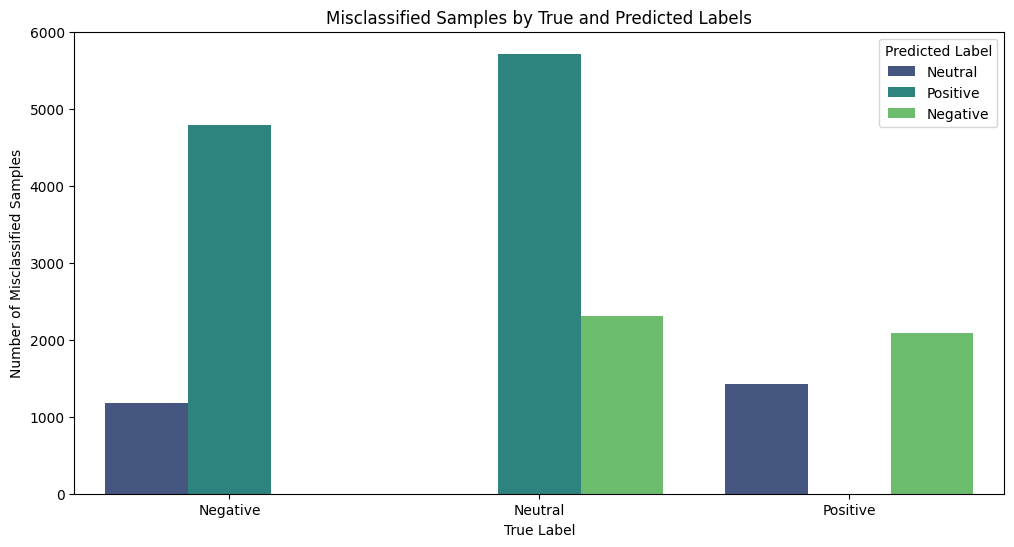

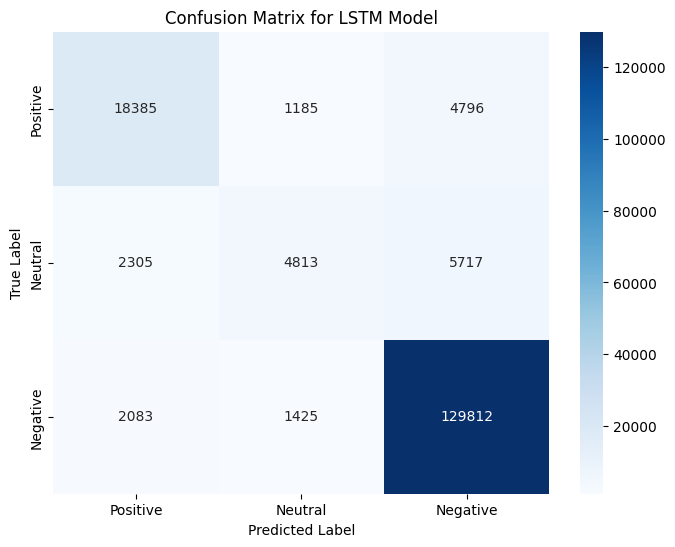

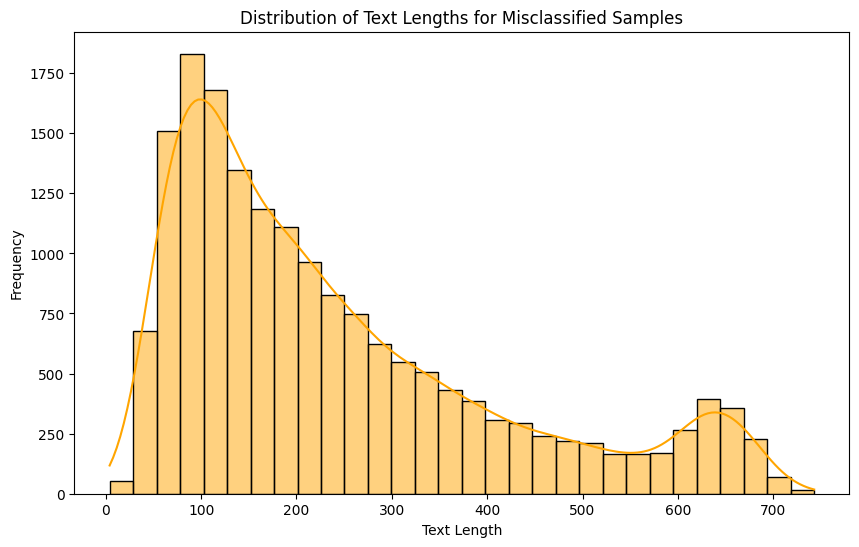

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- 1. Bar Plot for Misclassification Counts ---
plt.figure(figsize=(12, 6))
misclassification_counts = misclassified_lstm.groupby(['True Label', 'Predicted Label']).size().reset_index(name='Count')
sns.barplot(x='True Label', y='Count', hue='Predicted Label', data=misclassification_counts, palette='viridis')
plt.title('Misclassified Samples by True and Predicted Labels')
plt.xlabel('True Label')
plt.ylabel('Number of Misclassified Samples')
plt.legend(title='Predicted Label')
plt.show()

# --- 2. Heatmap for Confusion Matrix ---
cm_lstm = confusion_matrix(y_test_numeric, y_pred_lstm_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=reverse_mapping.values(), yticklabels=reverse_mapping.values())
plt.title("Confusion Matrix for LSTM Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# --- 3. Text Length Analysis for Misclassified Samples ---
misclassified_lstm['Text Length'] = misclassified_lstm['Text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(misclassified_lstm['Text Length'], kde=True, bins=30, color='orange')
plt.title('Distribution of Text Lengths for Misclassified Samples')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [36]:
# Decode text for X_test
X_test_text = tokenizer.sequences_to_texts(X_test)

# Reverse mapping for numeric labels to string labels
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
reverse_sentiment_mapping = {v: k for k, v in sentiment_mapping.items()}

# --- CNN Misclassified Samples ---
misclassified_cnn = pd.DataFrame({
    'Text': X_test_text,
    'True Label': [reverse_sentiment_mapping[label] for label in y_test_numeric],
    'Predicted Label': [reverse_sentiment_mapping[label] for label in y_pred_cnn_classes]
})
misclassified_cnn = misclassified_cnn[misclassified_cnn['True Label'] != misclassified_cnn['Predicted Label']]

# --- Logistic Regression Misclassified Samples ---
y_pred_logreg_numeric = [sentiment_mapping[label] for label in y_pred_logreg]  # Convert string predictions to numeric
misclassified_logreg = pd.DataFrame({
    'Text': X_test_text,
    'True Label': [reverse_sentiment_mapping[label] for label in y_test_numeric],
    'Predicted Label': [reverse_sentiment_mapping[label] for label in y_pred_logreg_numeric]
})
misclassified_logreg = misclassified_logreg[misclassified_logreg['True Label'] != misclassified_logreg['Predicted Label']]

# --- SVM Misclassified Samples ---
y_pred_svm_numeric = [sentiment_mapping[label] for label in y_pred_svm]  # Convert string predictions to numeric
misclassified_svm = pd.DataFrame({
    'Text': X_test_text,
    'True Label': [reverse_sentiment_mapping[label] for label in y_test_numeric],
    'Predicted Label': [reverse_sentiment_mapping[label] for label in y_pred_svm_numeric]
})
misclassified_svm = misclassified_svm[misclassified_svm['True Label'] != misclassified_svm['Predicted Label']]

# Display a few misclassified samples for verification
print("CNN Misclassified Samples:")
print(misclassified_cnn.head())

print("\nLogistic Regression Misclassified Samples:")
print(misclassified_logreg.head())

print("\nSVM Misclassified Samples:")
print(misclassified_svm.head())


CNN Misclassified Samples:
                                                 Text True Label  \
23  managed bite bean lick inside brain took told ...    Neutral   
29  ive looking coffee taste like home ever since ...   Positive   
54         love organic didnt think bad stick flavors   Positive   
55      dont keep refined sugar sugar way meant taste   Positive   
58  cookies id getting eight soft almost soggy coo...    Neutral   

   Predicted Label  
23        Positive  
29        Negative  
54         Neutral  
55        Negative  
58        Negative  

Logistic Regression Misclassified Samples:
                                                 Text True Label  \
2   pretty sad got peaches indeed delicious stated...   Negative   
5   good steaks delivery little overly impressed c...    Neutral   
21  im biggest oreo cookie eater youll ever find d...   Negative   
22  think product good better freeze dried fruit w...   Positive   
23  managed bite bean lick inside brain took told ... 

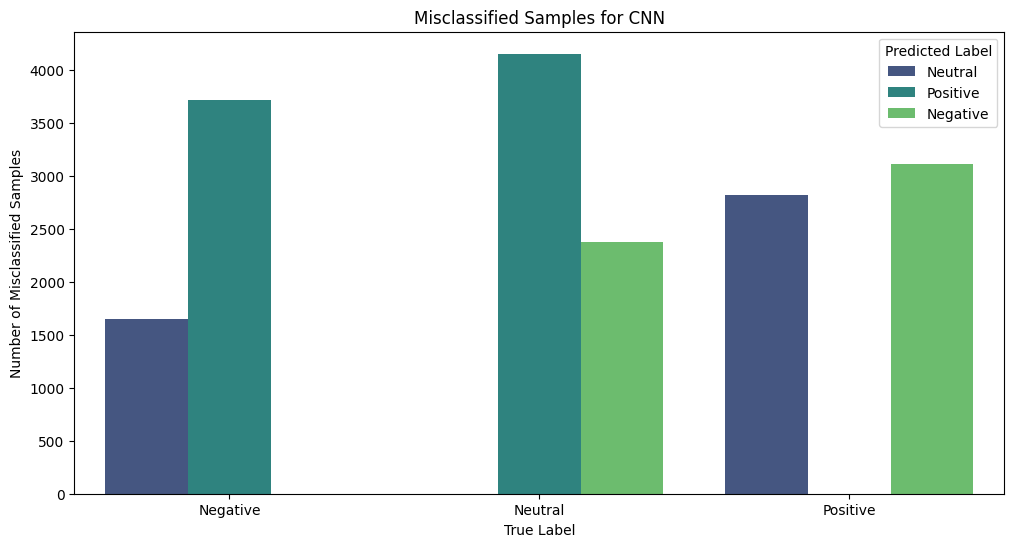

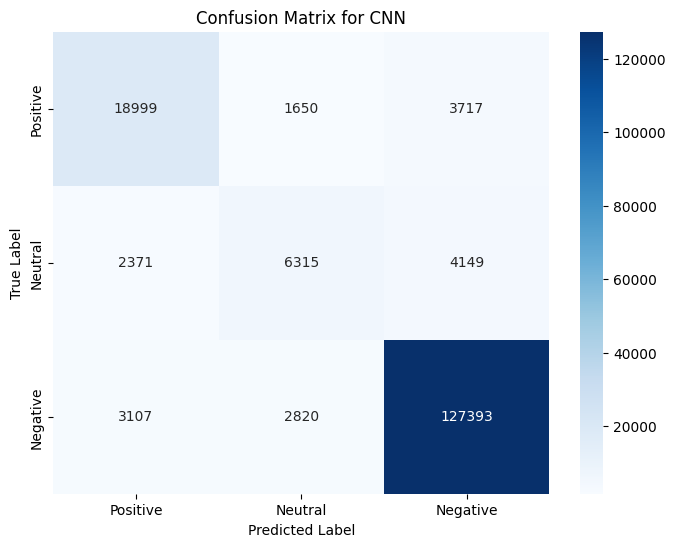

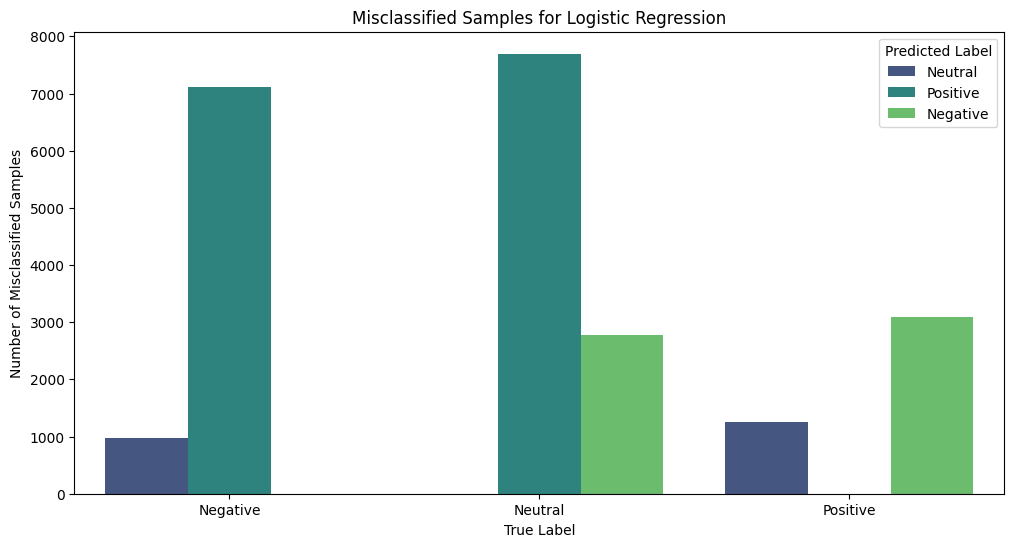

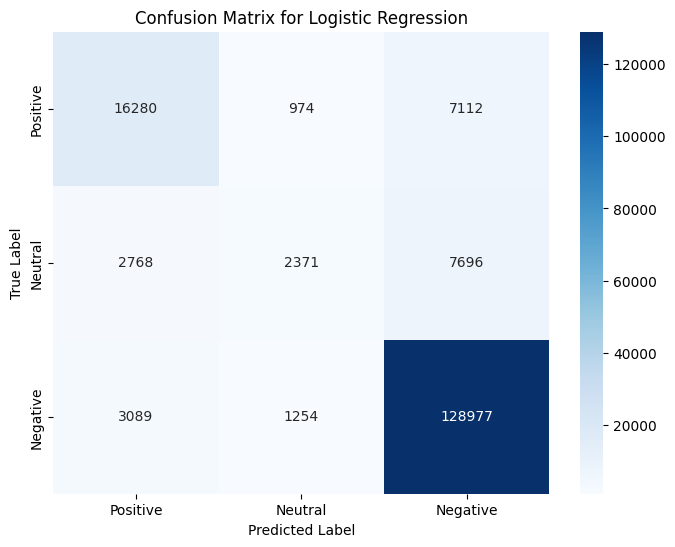

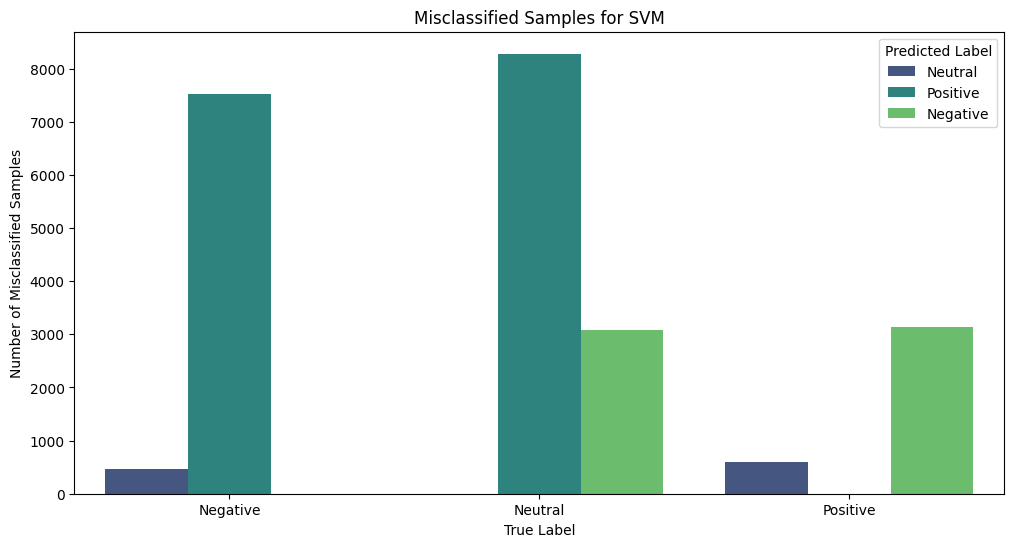

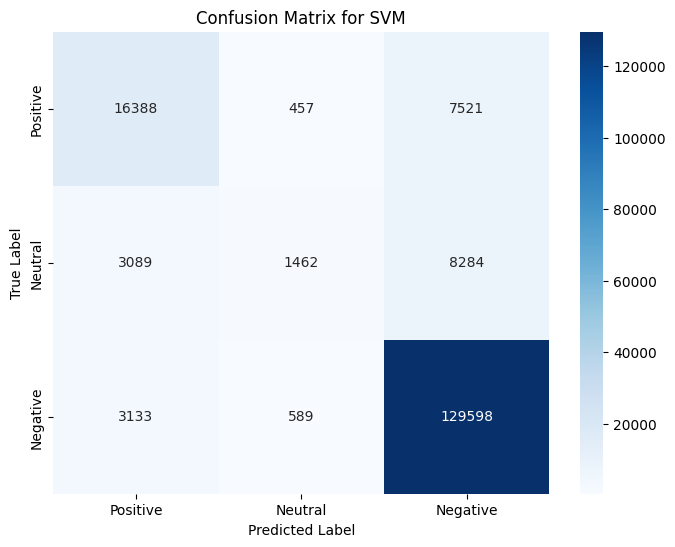

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to create bar plot for misclassified samples
def plot_misclassified_bar(data, title):
    plt.figure(figsize=(12, 6))
    misclassification_counts = data.groupby(['True Label', 'Predicted Label']).size().reset_index(name='Count')
    sns.barplot(x='True Label', y='Count', hue='Predicted Label', data=misclassification_counts, palette='viridis')
    plt.title(title)
    plt.xlabel('True Label')
    plt.ylabel('Number of Misclassified Samples')
    plt.legend(title='Predicted Label')
    plt.show()

# Function to create heatmap for confusion matrix
def plot_confusion_matrix(cm, title, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Reverse mapping for labels
labels = list(reverse_sentiment_mapping.values())

# --- CNN Visualizations ---
plot_misclassified_bar(misclassified_cnn, "Misclassified Samples for CNN")
cm_cnn = confusion_matrix(y_test_numeric, y_pred_cnn_classes)
plot_confusion_matrix(cm_cnn, "Confusion Matrix for CNN", labels)

# --- Logistic Regression Visualizations ---
plot_misclassified_bar(misclassified_logreg, "Misclassified Samples for Logistic Regression")
cm_logreg = confusion_matrix(y_test_numeric, y_pred_logreg_numeric)
plot_confusion_matrix(cm_logreg, "Confusion Matrix for Logistic Regression", labels)

# --- SVM Visualizations ---
plot_misclassified_bar(misclassified_svm, "Misclassified Samples for SVM")
cm_svm = confusion_matrix(y_test_numeric, y_pred_svm_numeric)
plot_confusion_matrix(cm_svm, "Confusion Matrix for SVM", labels)


In [38]:
print("yes")

yes
